In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import FreqDist

In [6]:
data = pd.read_csv('../data/twitter_data.csv',encoding = "ISO-8859-1")
data

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
99984,99996,0,@Cupcake seems like a repeating problem hop...
99985,99997,1,@cupcake__ arrrr we both replied to each other...
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


In [7]:
data = data[['Sentiment','SentimentText']]

In [8]:
print(f"shape: {data.shape}")

shape: (99989, 2)


### Positive vs Negative sentiment in our Data

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

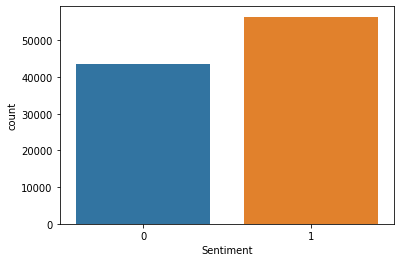

In [21]:
sns.countplot(x="Sentiment",data=data)

### Tweet lenght distribution

In [36]:
print(f"Average length of Positive tweets: {np.mean(data[data['Sentiment'] == 1]['SentimentText'].apply(lambda x: len(x)))}")
print(f"Average length of Negative tweets: {np.mean(data[data['Sentiment'] == 0]['SentimentText'].apply(lambda x: len(x)))}")

Average length of Positive tweets: 76.35372053066936
Average length of Negative tweets: 78.4455113479739


### Cleaning Text

In [193]:
def clean_text(text):
    import re
    #lower text
    text = text.lower()
    #removing mentions
    text = re.sub("@(\w+)","",text)
    #removing hashtags
    text = re.sub(r"#(\w+)","",text)
    #removing RT
    text = text.replace("RT","")
    #decontract
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    #removing numbers and special characters
    text = re.sub("[^A-Za-z ]+","",text)
    #remove links
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)

    
    #tokenize text
    text_tokenized = nltk.word_tokenize(text,language='english')
    
    #removing stopwords
    negtion_words = ['no','not','none','no','one','nobody','nothing','neither','nowhere','never','doesn\'t','isn\'t','wasn\'t','shouldn\'t','wouldn\'t','couldn\'t','won\'t','can\'t','don\'t']
    ## keeping negation words since it affects the sentiment of a text
    my_stopwords = set(negtion_words) ^ set(stopwords.words('english'))
    
    text_tokenized = [w for w in text_tokenized if w not in my_stopwords]
    
    #lemmetizing text
    lemmatizer = WordNetLemmatizer()
    text_lemmatized = [lemmatizer.lemmatize(w) for w in text_tokenized]
    
    #removing stopwords
    return ' '.join(text_lemmatized)

In [194]:
clean_text("@cep I'm happy i didn't watched that movie..")

'im happy not watched movie'

### Word Cloud

In [218]:
# def remove_stopwords(text):
#     text = nltk.word_tokenize(text,language="english")
#     cleaned = [w for w in text if w.lower() not in set(stopwords.words('english'))]
#     return ' '.join(cleaned)
    
# text_without_stopwords = data['SentimentText'].apply(remove_stopwords)

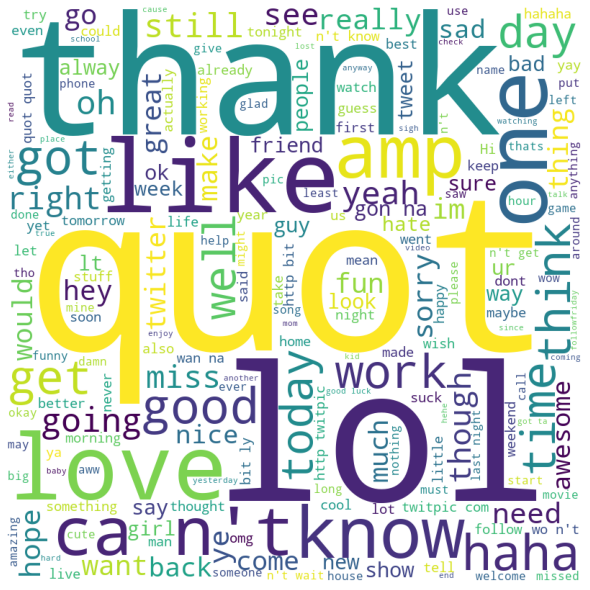

In [219]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(" ".join(data['SentimentText'])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

In [220]:
cleaned_data  = data["SentimentText"].apply(clean_text)

### Split data into Train - Test

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data,data['Sentiment'])
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (74991,)
X_test shape: (24998,)
y_train shape: (74991,)
y_test shape: (24998,)


In [227]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

### Modeling

#### 1.SVM

In [235]:
from sklearn.svm import SVC
svm = SVC(C=10000)
svm.fit(X_train_vect,y_train)
svm_preds = svm.predict(X_test_vect)

In [249]:
print("===== SVM Classification Report =====")
print(classification_report(y_test,svm_preds))

===== SVM Classification Report =====
              precision    recall  f1-score   support

           0       0.74      0.71      0.72     10886
           1       0.78      0.80      0.79     14112

    accuracy                           0.76     24998
   macro avg       0.76      0.76      0.76     24998
weighted avg       0.76      0.76      0.76     24998




- The recall means "how many of this class you find over the whole number of element of this class"

- The precision will be "how many are correctly classified among that class"

- The f1-score is the harmonic mean between precision & recall

- The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
   
*source: [StackExchange](https://datascience.stackexchange.com/a/64443)*

In [250]:
print("===== SVM Confusion Matrix =====")
confusion_matrix(y_test,svm_preds)

===== SVM Confusion Matrix =====


array([[ 7741,  3145],
       [ 2763, 11349]], dtype=int64)

In [247]:
roc_auc_score(y_test,svm_preds)

0.7576530026396007

In [259]:
accuracy_score(y_test,svm_preds)

0.763661092887431

#### 2.Naive Bayes

In [253]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_vect,y_train)
mnb_preds = mnb.predict(X_test_vect)

In [254]:
print("===== MultinomialNB Classification Report =====")
print(classification_report(y_test,mnb_preds))

===== MultinomialNB Classification Report =====
              precision    recall  f1-score   support

           0       0.80      0.56      0.65     10886
           1       0.72      0.89      0.80     14112

    accuracy                           0.74     24998
   macro avg       0.76      0.72      0.73     24998
weighted avg       0.75      0.74      0.74     24998



In [256]:
print("===== MultinomialNB Confusion Matrix =====")
confusion_matrix(y_test,mnb_preds)

===== MultinomialNB Confusion Matrix =====


array([[ 6044,  4842],
       [ 1537, 12575]], dtype=int64)

In [257]:
roc_auc_score(y_test,mnb_preds)

0.7231470628088335

In [258]:
accuracy_score(y_test,mnb_preds)

0.7448195855668454

### saving the model

In [307]:
from sklearn.pipeline import Pipeline
pipline = Pipeline([
    ('Tfidf', tfidf),
    ('SVM', svm)
])

In [308]:
pipline.predict([clean_text("I am happy")])

array([1], dtype=int64)

In [309]:
pipline.predict([clean_text("I am not happy")])

array([0], dtype=int64)

In [310]:
pipline.score(X_test,y_test)

0.763661092887431

In [312]:
import pickle
pickle.dump(pipline,open("twitter_svm_model.pkl","wb"))